In [93]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from random import sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## read in data

In [94]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [95]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [96]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [97]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [98]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

## create sequences

In [99]:
census_enum_seq_before = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
print('...')
census_enum_seq_before.apply_sequencing(after=False, enumerator_dist = True, dwelling = False, 
                                        fixed = False, distance = True, enumerator=True, d=0.1)
print('====')
census_enum_seq_after = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
print('...')
census_enum_seq_after.apply_sequencing(after=True, enumerator_dist = True, dwelling = False, 
                                       fixed = False, distance = True, enumerator=True,d=0.1)

...
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
====
...
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


In [100]:
merged_df = census_enum_seq_before.df.merge(census_enum_seq_after.df[['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'enum_dist_id', 'dwelling_id']], 
             on= ['dwelling_id','block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y'])
merged_df.rename(columns={'enum_dist_id_x': 'enum_dist_id_BEFORE',
                  'enum_dist_id_y': 'enum_dist_id_AFTER'}, inplace=True)

In [101]:
merged_df_1 = merged_df[['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'dwelling_id', 'sequence_id', 'enum_seq', 'dist',
   'enum_dist_id_BEFORE', 'enum_dist_id_AFTER']].copy()
merged_df_1.dropna(subset=['CD_ADDRESS'], inplace=True)

In [102]:
(merged_df_1['enum_dist_id_BEFORE'] != merged_df_1['enum_dist_id_AFTER']).sum()

19726

In [123]:
merged_df_1['enum_dist_id_BEFORE'] != merged_df_1['enum_dist_id_AFTER']

146       False
147       False
148       False
149       False
150       False
          ...  
386732    False
386733    False
386734    False
386735    False
386736    False
Length: 120187, dtype: bool

In [104]:
merged_df_1['enum_dist_id_BEFORE'].unique().shape

(163,)

In [105]:
merged_df_1['enum_dist_id_AFTER'].unique().shape

(187,)

In [92]:
merged_df_1.drop_duplicates()

,block_num,CD_ADDRESS,cd_X,cd_Y,dwelling_id,sequence_id,enum_seq,dist,enum_dist_id_BEFORE,enum_dist_id_AFTER
146,1259.0,24 Division,-73.996688,40.714137,4,38.0,1.0,0.008744,38,38.0
291,1259.0,28 Division,-73.996562,40.714150,6,38.0,1.0,0.007475,38,38.0
344,1259.0,32 Division,-73.996454,40.714154,8,38.0,1.0,0.053283,38,38.0
1306,1258.0,#NAME?,-73.995682,40.714205,15,38.0,1.0,0.007568,38,38.0
1631,1258.0,52 Division,-73.995573,40.714214,17,38.0,1.0,0.024798,38,38.0
...,...,...,...,...,...,...,...,...,...,...
374285,1266.0,38 Hester,-73.989606,40.715446,1923,1922.0,49.0,0.466540,1922,1922.0
377255,184.0,34 Bayard,-73.996357,40.714945,1931,1930.0,49.0,0.218979,1930,1930.0
381694,1270.0,85 Forsyth,-73.993276,40.717627,1959,1970.0,51.0,0.063473,Ward_Num,1958.0
386075,186.0,13 Eldridge,-73.993758,40.714793,1968,1970.0,52.0,0.004445,1970,1970.0


In [119]:
selected_cols = ['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'sequence_id', 'dist', 'enum_dist', 'enum_dist_id']

In [134]:
pd.set_option('max_rows', 100)
merged_df_1.loc[merged_df_1['enum_dist_id_BEFORE'] == 161]

,block_num,CD_ADDRESS,cd_X,cd_Y,dwelling_id,sequence_id,enum_seq,dist,enum_dist_id_BEFORE,enum_dist_id_AFTER
26524,203.0,108 Ludlow,-73.988725,40.719202,162,161.0,6.0,0.114402,161,161.0
26525,203.0,108 Ludlow,-73.988725,40.719202,162,161.0,6.0,0.114402,161,161.0
26526,203.0,108 Ludlow,-73.988725,40.719202,162,161.0,6.0,0.114402,161,161.0
26527,203.0,108 Ludlow,-73.988725,40.719202,162,161.0,6.0,0.114402,161,161.0
26528,203.0,108 Ludlow,-73.988725,40.719202,162,161.0,6.0,0.114402,161,161.0
...,...,...,...,...,...,...,...,...,...,...
29312,1285.0,36 Fulton market,-73.987323,40.719705,173,172.0,6.0,0.571583,161,172.0
29313,1285.0,36 Fulton market,-73.987323,40.719705,173,172.0,6.0,0.571583,161,172.0
29314,1285.0,36 Fulton market,-73.987323,40.719705,173,172.0,6.0,0.571583,161,172.0
29315,1285.0,36 Fulton market,-73.987323,40.719705,173,172.0,6.0,0.571583,161,172.0


In [132]:
pd.set_option('max_rows', 100)
merged_df_1.loc[merged_df_1['enum_dist_id_BEFORE'] != merged_df_1['enum_dist_id_AFTER']].drop_duplicates()

,block_num,CD_ADDRESS,cd_X,cd_Y,dwelling_id,sequence_id,enum_seq,dist,enum_dist_id_BEFORE,enum_dist_id_AFTER
7147,1266.0,176° Division,-73.989548,40.714658,73,74.0,2.0,0.003828,69,74.0
7163,1266.0,178 Division,-73.989493,40.714661,74,74.0,2.0,0.004918,69,74.0
7563,1266.0,180} Division,-73.989421,40.714667,75,74.0,2.0,0.272203,69,74.0
12381,195.0,29 Norfolk,-73.988706,40.715938,109,127.0,3.0,0.002067,105,109.0
12445,195.0,31 Norfolk,-73.988680,40.715988,110,127.0,3.0,0.008076,105,109.0
20018,201.0,155 Forsyth,-73.991684,40.720667,137,140.0,5.0,0.096417,133,137.0
20274,188.0,32 Orchard,-73.991392,40.715718,138,140.0,5.0,0.085766,133,137.0
27308,1285.0,101 Norfolk,-73.987070,40.719116,163,172.0,6.0,0.009591,161,172.0
28413,1285.0,109 Norfolk,-73.986949,40.719367,167,172.0,6.0,0.006520,161,172.0
28903,1285.0,115 Norfolk,-73.987030,40.719191,170,172.0,6.0,0.009026,161,172.0


In [161]:
merged_df_1.loc[merged_df_1['enum_dist_id_BEFORE'] == 1243]['enum_dist_id_AFTER'].unique()#[selected_cols].drop_duplicates()

array([1243., 1256.])

In [154]:

def BEFORE_vs_AFTER(before_seq, after_seq):
    
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].scatter(x=merged_df_1.loc[:, x_col], y=merged_df_1.loc[:, y_col], s=2, color='grey')
    ax[1].scatter(x=merged_df_1.loc[:, x_col], y=merged_df_1.loc[:, y_col], s=2, color='grey')

#     before_seq = [69]
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(before_seq))]
    for seq, color in zip(before_seq, colors):
        ss_df = merged_df_1.loc[merged_df_1['enum_dist_id_BEFORE'] == seq].drop_duplicates()
        ax[0].plot(ss_df.loc[:, x_col], ss_df.loc[:, y_col], label=str(seq),
                           color=color)
        ax[0].scatter(ss_df.loc[:, x_col], ss_df.loc[:, y_col],
                           color=color, s=20)
        ax[0].set_title('BEFORE')

#     after_seq = [69, 74]
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(after_seq))]
    for seq, color in zip(after_seq, colors):
        ss_df = merged_df_1.loc[merged_df_1['enum_dist_id_AFTER'] == seq].drop_duplicates()
        ax[1].plot(ss_df.loc[:, x_col], ss_df.loc[:, y_col], label=str(seq),
                           color=color)
        ax[1].scatter(ss_df.loc[:, x_col], ss_df.loc[:, y_col],
                           color=color, s=20)
        ax[1].set_title('AFTER')
    ax[0].legend()
    ax[1].legend()



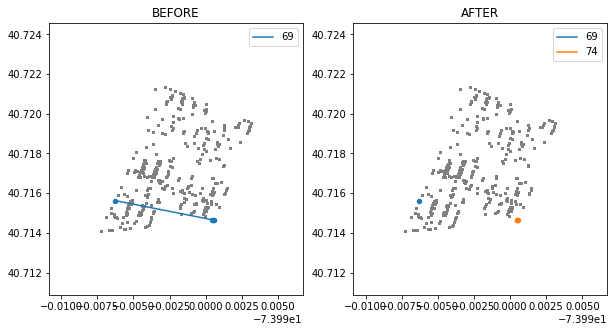

In [155]:
BEFORE_vs_AFTER(before_seq=[69], after_seq=[69,74])

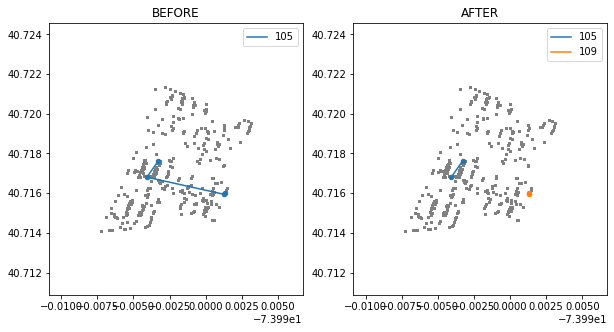

In [158]:
BEFORE_vs_AFTER(before_seq=[105], after_seq=[105,109])

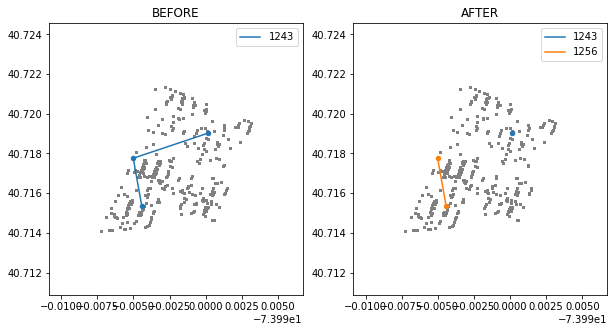

In [162]:
BEFORE_vs_AFTER(before_seq=[1243], after_seq=[1243,1256])

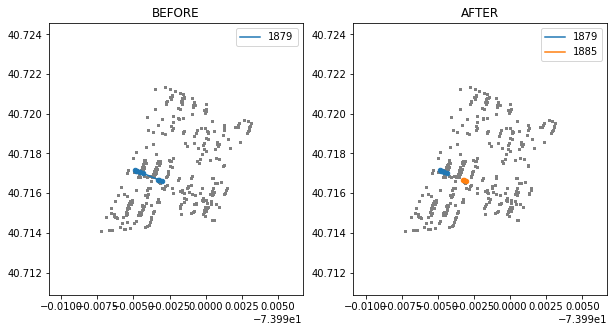

In [160]:
BEFORE_vs_AFTER(before_seq=[1879], after_seq=[1879,1885])

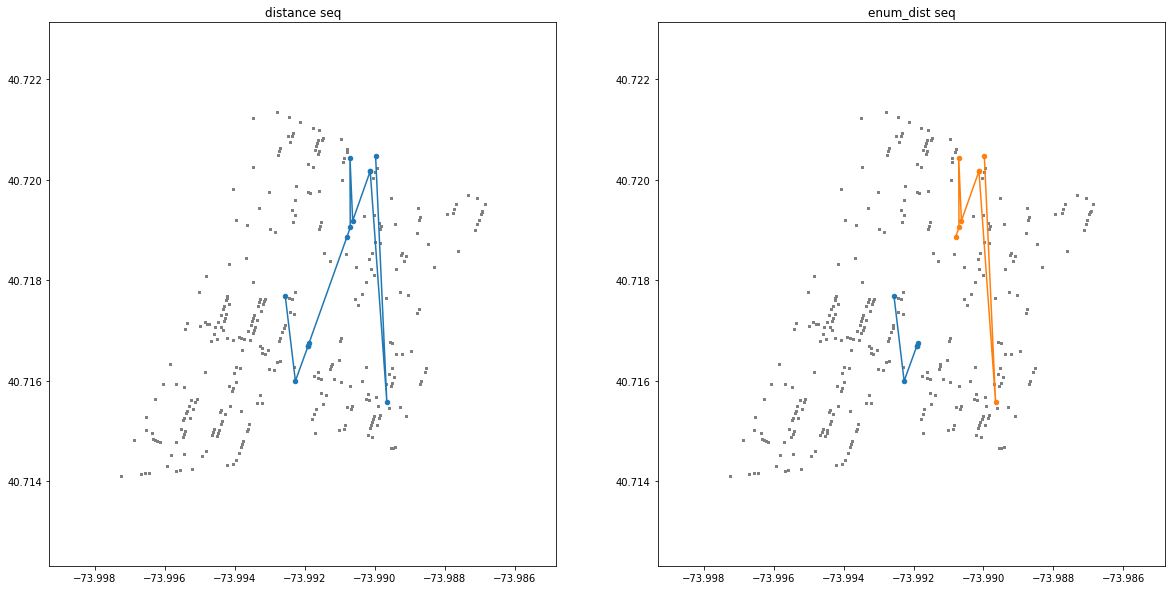

In [163]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].scatter(x=merged_df_1.loc[:, x_col], y=merged_df_1.loc[:, y_col], s=2, color='grey')
ax[1].scatter(x=merged_df_1.loc[:, x_col], y=merged_df_1.loc[:, y_col], s=2, color='grey')
dis_seq = [1483]
colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(dis_seq))]
for seq, color in zip(dis_seq, colors):
    ss_df = merged_df_1.loc[merged_df_1['sequence_id'] == seq].drop_duplicates()
    ax[0].plot(ss_df.loc[:, x_col], ss_df.loc[:, y_col], label=str(seq),
                       color=color)
    ax[0].scatter(ss_df.loc[:, x_col], ss_df.loc[:, y_col],
                       color=color, s=20)
    ax[0].set_title('distance seq')
    
enum_dis_seq = [1483, 1457]
colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(enum_dis_seq))]
for seq, color in zip(enum_dis_seq, colors):
    ss_df = merged_df_1.loc[merged_df_1['enum_dist_id_AFTER'] == seq].drop_duplicates()
    ax[1].plot(ss_df.loc[:, x_col], ss_df.loc[:, y_col], label=str(seq),
                       color=color)
    ax[1].scatter(ss_df.loc[:, x_col], ss_df.loc[:, y_col],
                       color=color, s=20)
    ax[1].set_title('enum_dist seq')
    


## Test Performance

In [13]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)


for selected_d in [0.1,0.08, 0.05, 0.035, 0.03]:
    census_enum_seq.apply_sequencing(d=selected_d,enumerator_dist = True, dwelling = True, fixed = True, distance = True)

    similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
    census_enum_seq.apply_similarity(sim_columns=similar_cols)

    all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
                "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
                "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
                "enum_dist_order"]

    transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
    # define pipeline
    pipeline = Pipeline(steps=[('preprocess', transformer), 
                               ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                           n_estimators = 50))])

    interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                                 KMeans(5), block_centroids)
    score, model = interpolate_sequences.kmeans_best(5)
    interpolate_sequences.set_clustering_algo(model)
    interpolate_sequences.apply_clustering(algo_fit = True)
#     interpolate_sequences.clustervis(kmeans = True)
    interpolate_sequences.cross_validate_model(k=10)
    print('Current d: ', selected_d)
    print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
    print('Test score:', interpolate_sequences.test_score)
    print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 90, cost: 2729.0
n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration
Current d:  0.1
avg Training score: 0.9154594719053811
Test score: [0.5834586466165413, 0.5624483043837882, 0.5986078886310905, 0.5694564279551337, 0.53419452887538, 0.41106382978723405, 0.5166508087535681, 0.515052888527258, 0.4850818094321463, 0.5837275307473982]
avg Test score: 0.5359742663709539
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 94, cost: 2698.0
Run 1, iteration: 2/100, moves: 5, cost: 2698.0
n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration
Current d:  0.08
avg Training score: 0.9162

### The CV score is best at 0.63 when d = 0.05